In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from pathlib import Path
root_folder = Path().absolute().parent / "experiments"
experiment_path = root_folder/ "test_score_matrices_2020-06-12_14h30_bis"

pd.options.display.max_columns = 100

df=pd.read_csv(experiment_path / "results.csv")

In [2]:
df

,aggregation_weighting,amounts_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,mpl_test_score,multi_partner_learning_approach,nb_samples_used,partners_count,samples_split_option,scenario_name,short_scenario_name,single_partner_test_mode,test_data_samples_count,train_data_samples_count,random_state,scenario_id
0,data_volume,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1050.283037,20.0,9.0,0.9881,fedavg,48000.0,3.0,random,scenario_1_repeat_1_2020-06-12_14h30_e52,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,0
1,uniform,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1061.069882,20.0,9.0,0.9881,fedavg,48000.0,3.0,random,scenario_2_repeat_1_2020-06-12_14h48_bbb,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,1
2,data_volume,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,912.695397,20.0,7.0,0.8431,fedavg,48000.0,3.0,stratified,scenario_3_repeat_1_2020-06-12_15h05_b6b,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,2
3,uniform,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,2120.608498,20.0,16.0,0.9683,fedavg,48000.0,3.0,stratified,scenario_4_repeat_1_2020-06-12_15h20_564,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,3
4,data_volume,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,649.257789,20.0,8.0,0.9889,fedavg,48000.0,2.0,random,scenario_5_repeat_1_2020-06-12_15h56_d9a,"2 [0.3, 0.7]",global,10000.0,48000.0,0,4
5,uniform,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,726.866714,20.0,9.0,0.9882,fedavg,48000.0,2.0,random,scenario_6_repeat_1_2020-06-12_16h07_757,"2 [0.3, 0.7]",global,10000.0,48000.0,0,5
6,data_volume,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,432.682789,20.0,5.0,0.8931,fedavg,48000.0,2.0,stratified,scenario_7_repeat_1_2020-06-12_16h19_7f5,"2 [0.3, 0.7]",global,10000.0,48000.0,0,6
7,uniform,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,744.926903,20.0,9.0,0.9787,fedavg,48000.0,2.0,stratified,scenario_8_repeat_1_2020-06-12_16h26_2dc,"2 [0.3, 0.7]",global,10000.0,48000.0,0,7
8,data_volume,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1251.997197,20.0,9.0,0.9876,fedavg,48000.0,3.0,random,scenario_1_repeat_2_2020-06-12_16h38_49f,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,1,0
9,uniform,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1274.940537,20.0,9.0,0.9862,fedavg,48000.0,3.0,random,scenario_2_repeat_2_2020-06-12_16h59_1b5,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,1,1


In [ ]:
def normalize_function ()

In [15]:
def aggregated_score_function (score_matrix_per_partner,score_matrix_collective_models, agg_function,
                               init_comp_rounds_skipped, final_comp_rounds_skipped):
    
    # function that takes:
    # as input the 2 scoring matrices at the end of the simulation, an aggregation function
    # the proportion of initial and final computation rounds to be skipped
    # as output the array of contributivity score and normalized contributivity score per partner
    
    (epoch_count,minibatch_count,partners_count) = score_matrix_per_partner.shape

    # Calculate absolute and relative deltas of performance between partner and collective model for each round
    score_matrix_collective_models = score_matrix_collective_models[:,1:]
    score_matrix_performance_abs = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
    score_matrix_performance_rel = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))

    scores_matrix_collective_reshape=np.reshape(score_matrix_collective_models,
                                                    (epoch_count * minibatch_count ))
    score_matrix_per_partner_reshape=np.reshape(score_matrix_per_partner,
                                                    (epoch_count * minibatch_count,partners_count ))



    score_matrix_performance_abs = score_matrix_per_partner_reshape - scores_matrix_collective_reshape[:,None]
    score_matrix_performance_rel = np.divide(score_matrix_performance_abs, scores_matrix_collective_reshape[:,None])
    
    score_matrix_performance_abs_reg = score_matrix_performance_abs + np.array(np.abs(np.min(score_matrix_performance_abs,axis=1))).transpose()[:,None]
    score_matrix_performance_rel_reg = score_matrix_performance_rel + np.array(np.abs(np.min(score_matrix_performance_rel,axis=1))).transpose()[:,None]

    first_comp_round_kept = int(np.round(epoch_count * minibatch_count * init_comp_rounds_skipped))
    last_comp_round_kept = int(np.round (epoch_count * minibatch_count * (1-final_comp_rounds_skipped)))

    scores_array_abs = score_matrix_performance_abs_reg [first_comp_round_kept: last_comp_round_kept , :]
    scores_array_rel = score_matrix_performance_rel_reg [first_comp_round_kept: last_comp_round_kept , :]

    comp_rounds_count = scores_array_abs.shape[0]

    # calculate contributivity scores

    if agg_function == "Uniform incremental increase":

        # compute the average delta of performance between collective model and partner model 
        # for each computation round

        contributivity_scores = scores_array_abs.mean(axis= 0)

    elif agg_function == "Relative incremental increase":

        # compute the average relative increase of performance between collective model and partner model
        # for each computation round

        contributivity_scores = scores_array_rel.mean(axis= 0)

    elif agg_function == "Weighted average increase":

        # compute the relative increase of performance between collective model and partner model 
        # for each computation round and gives more weight to the last rounds, following a uniform function

        contributivity_scores= np.array(np.arange(comp_rounds_count)).dot(scores_array_rel)

    elif agg_function == "Gaussian average increase":

        # compute the relative increase of performance between collective model and partner model 
        # for each computation round and gives more weight to the rounds, following a normal function

        normal_distrib= np.random.normal(0,1,comp_rounds_count)
        arranged_normal_distrib = np.sort(normal_distrib)+np.abs(min(normal_distrib))
        contributivity_scores= arranged_normal_distrib.dot(scores_array_rel)

    else :
        print ("Unrecognized aggregation function")


    normalized_contributivity_scores = contributivity_scores / np.sum(contributivity_scores)
    
    return (contributivity_scores, normalized_contributivity_scores)
    

In [16]:
# plot curves of normalized contributivity scores with x function

In [17]:
def plot_init_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_function, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped):

    partners_count = score_matrix_per_partner.shape[2]
    scores_array=np.zeros(partners_count)
    
    for i in np.arange(init_comp_rounds_skipped_min,init_comp_rounds_skipped_max,step):
        scores= aggregated_score_function(score_matrix_per_partner,
                                          score_matrix_collective_models,
                                         agg_function=agg_function,
                                          init_comp_rounds_skipped=i,
                                         final_comp_rounds_skipped = final_comp_rounds_skipped)[1]
        scores_array=np.vstack([scores_array,scores])
    
    scores_array=scores_array[1:,:]
    
    plt.plot(np.arange(init_comp_rounds_skipped_min, init_comp_rounds_skipped_max, step), scores_array);
    plt.legend(labels=np.arange(partners_count)+1)
    plt.xlabel("proportion of initial \n computation rounds skipped \n " +str(agg_function))
    plt.ylabel ("normalized contributivity scores")
    

In [18]:
def plot_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_function, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max):

    partners_count = score_matrix_per_partner.shape[2]
    scores_array=np.zeros(partners_count)
    
    
    for i in np.arange(final_comp_rounds_skipped_min,final_comp_rounds_skipped_max,step):
        
        scores= aggregated_score_function(score_matrix_per_partner,
                                          score_matrix_collective_models,
                                         agg_function=agg_function,
                                          init_comp_rounds_skipped=init_comp_rounds_skipped,
                                         final_comp_rounds_skipped = i)[1]
        scores_array=np.vstack([scores_array,scores])
    
    scores_array=scores_array[1:,:]
    
    plt.plot(np.arange(final_comp_rounds_skipped_min, final_comp_rounds_skipped_max, step), scores_array);
    plt.legend(labels=np.arange(partners_count)+1)
    plt.xlabel("proportion of final \n computation rounds skipped \n" +str(agg_function))
    plt.ylabel ("normalized contributivity scores")

In [19]:
def plot_multiple_function_init_round_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped):
    
    fig=plt.figure(figsize=(15,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i,func in enumerate(agg_functions):
        plt.subplot(1,4,i+1)
        plot_init_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                             func, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                                 step, final_comp_rounds_skipped)

In [20]:
def plot_multiple_function_last_rounds_skipped (score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max):
    
    fig=plt.figure(figsize=(15,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i,func in enumerate(agg_functions):
        plt.subplot(1,4,i+1)
        plot_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                                 func, init_comp_rounds_skipped,
                                 step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [21]:
def plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models,scenario_name):
    
    fig=plt.figure(figsize=(15,4))
    fig.suptitle(str("scenario: " + scenario_name), fontsize=16)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    partner_idx = 0
    plt.subplot(1,2,1)
    plt.plot(score_matrix_per_partner[:, 0, :])
    plt.legend(np.arange(score_matrix_per_partner.shape[2])+1)
    plt.xlabel("Epoch")
    plt.ylabel("Local validation score")

    plt.subplot(1,2,2)
    plt.plot(score_matrix_collective_models[:, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Global validation score")

In [22]:
# test on random matrices with increasing performance

In [23]:
epoch_count = 50
minibatch_count = 20
partners_count = 3

In [24]:
#score_matrix_collective_models.shape=(epoch_count, minibatch_count +1)
# definition of a dummy score_matrix_collective_models with uniform increasing performance

score_matrix_collective_models=np.array(np.linspace(0.3,0.98,epoch_count*(minibatch_count+1))).reshape(epoch_count,minibatch_count+1)

In [25]:
# score_matrix_per_partner.shape = (epoch_count, minibatch_count, partners_count)
# definition of a dummy score_matrix_per_partner with uniform increasing performance and normal noise for each partner

score_matrix_per_partner = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
for i in range (partners_count):
    score_matrix_per_partner_temp= np.array(np.linspace(0.3,0.98,epoch_count*minibatch_count)) +np.random.random(epoch_count*minibatch_count)/100
    score_matrix_per_partner_temp=score_matrix_per_partner_temp.reshape(epoch_count,minibatch_count)
    score_matrix_per_partner[:,:,i]=score_matrix_per_partner_temp

In [26]:
matrix_test = aggregated_score_function(score_matrix_per_partner,score_matrix_collective_models,
                                 "Uniform incremental increase",0.2,0.1)
matrix_test

(array([0.00693464, 0.00674428, 0.00702695]),
 array([0.3349118 , 0.32571816, 0.33937004]))

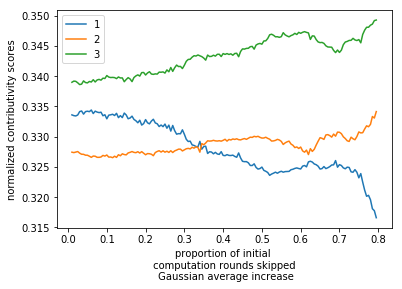

In [27]:
plot_init_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         "Gaussian average increase", 0.01,0.8,0.005,0.01)

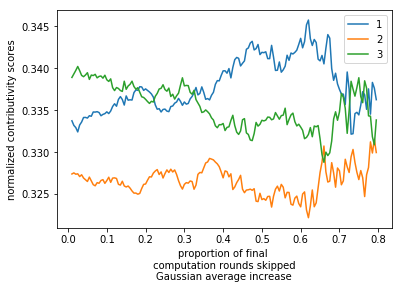

In [28]:
plot_last_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         "Gaussian average increase", 0.01,0.005,0.01,0.8)

In [29]:
agg_functions= ["Uniform incremental increase","Relative incremental increase",
                "Weighted average increase","Gaussian average increase"]

step = 0.05

init_comp_rounds_skipped_min = 0.01
init_comp_rounds_skipped_max = 0.8
init_comp_rounds_skipped = 0.01


final_comp_rounds_skipped_min = 0.01
final_comp_rounds_skipped_max = 0.8
final_comp_rounds_skipped = 0.01

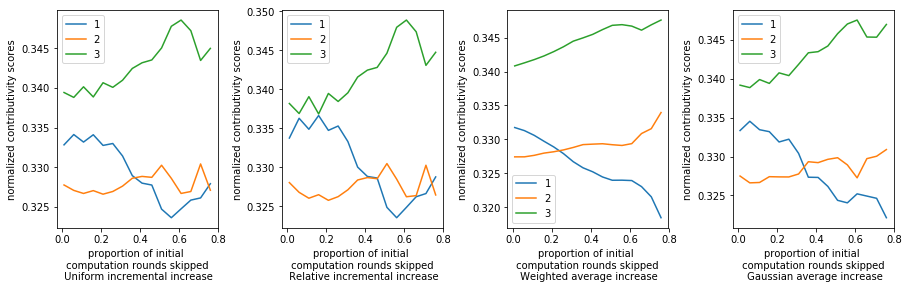

In [30]:
plot_multiple_function_init_round_skipped (score_matrix_per_partner,score_matrix_collective_models,
                             agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                                 step, final_comp_rounds_skipped)

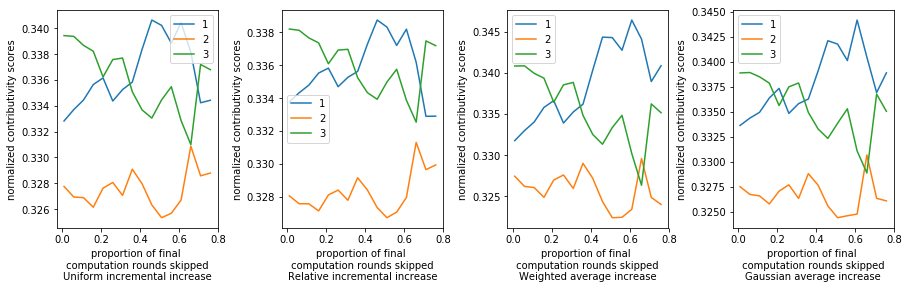

In [31]:
plot_multiple_function_last_rounds_skipped (score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

## Test on real simulations

### define parameters to test

In [32]:
agg_functions= ["Uniform incremental increase","Relative incremental increase",
                "Weighted average increase","Gaussian average increase"]

step = 0.05

init_comp_rounds_skipped_min = 0.01
init_comp_rounds_skipped_max = 0.8
init_comp_rounds_skipped = 0.01


final_comp_rounds_skipped_min = 0.01
final_comp_rounds_skipped_max = 0.8
final_comp_rounds_skipped = 0.01

### define scenarios

In [33]:
scenario_name = df.scenario_name.iloc[0]
sh_scenario_name = str(df.aggregation_weighting.iloc[0] + " "+ df.short_scenario_name.iloc[0] + " " + df.samples_split_option.iloc[0])
scenario_path = experiment_path / scenario_name
history_data_path = scenario_path / "history_data.p"

In [34]:
with open(history_data_path, 'rb') as f:
    loss_data = pickle.load(f)

In [35]:
score_matrix_per_partner = loss_data["score_matrix_per_partner"]
score_matrix_collective_models = loss_data["score_matrix_collective_models"]

early_stop_epoch = int(df.mpl_nb_epochs_done.iloc[0])
score_matrix_per_partner = score_matrix_per_partner[:early_stop_epoch,:,:]
score_matrix_collective_models = score_matrix_collective_models [:early_stop_epoch, :]

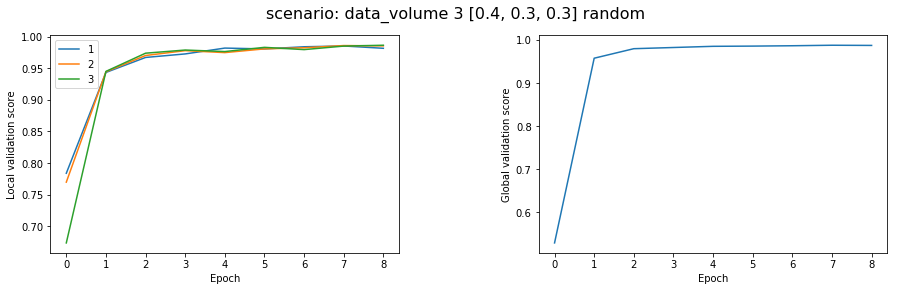

In [36]:
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

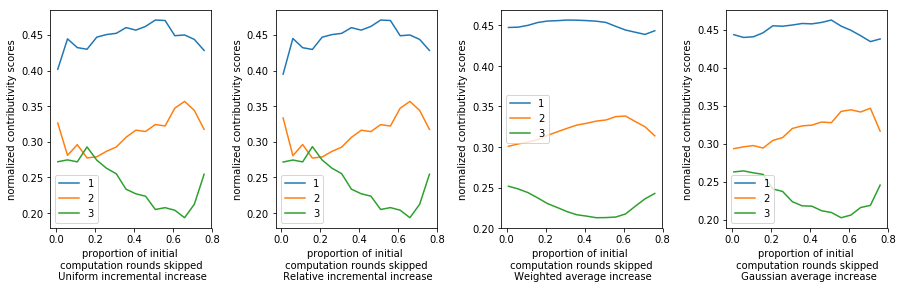

In [37]:
plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

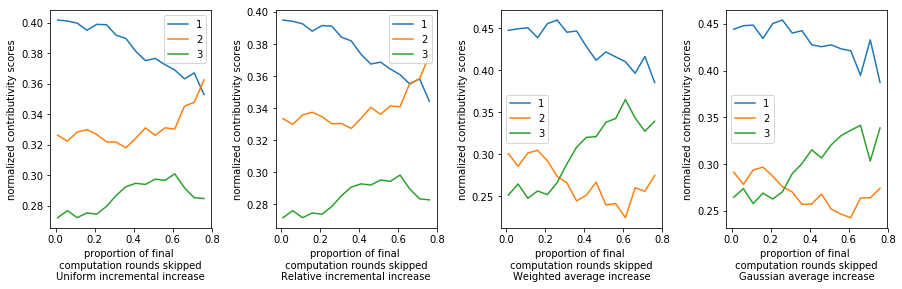

In [38]:
plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [39]:
def define_scenario (scenario_num):
    scenario_name = df.scenario_name.iloc[scenario_num]
    sh_scenario_name = str(df.aggregation_weighting.iloc[scenario_num] + " "+ df.short_scenario_name.iloc[scenario_num] + " " + df.samples_split_option.iloc[scenario_num])
    scenario_path = experiment_path / scenario_name
    history_data_path = scenario_path / "history_data.p"
    
    with open(history_data_path, 'rb') as f:
        loss_data = pickle.load(f)
    
    score_matrix_per_partner = loss_data["score_matrix_per_partner"]
    score_matrix_collective_models = loss_data["score_matrix_collective_models"]

    early_stop_epoch = int(df.mpl_nb_epochs_done.iloc[scenario_num])
    score_matrix_per_partner = score_matrix_per_partner[:early_stop_epoch,:,:]
    score_matrix_collective_models = score_matrix_collective_models [:early_stop_epoch, :]
    
    
    return score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name
    

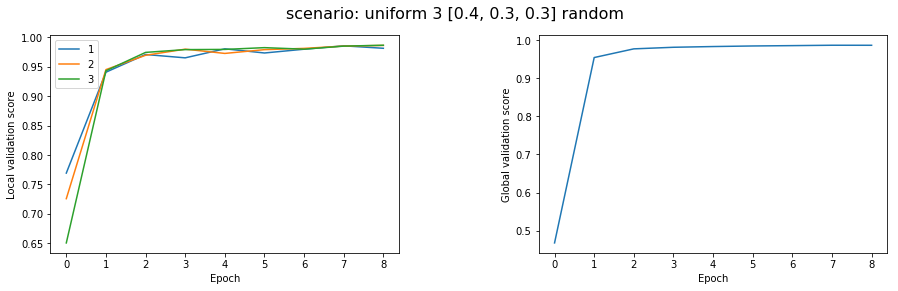

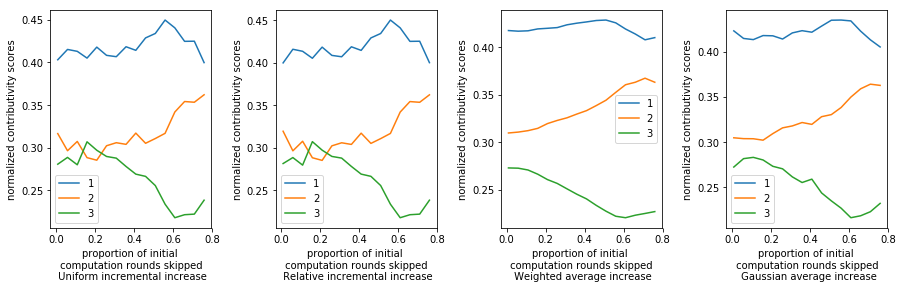

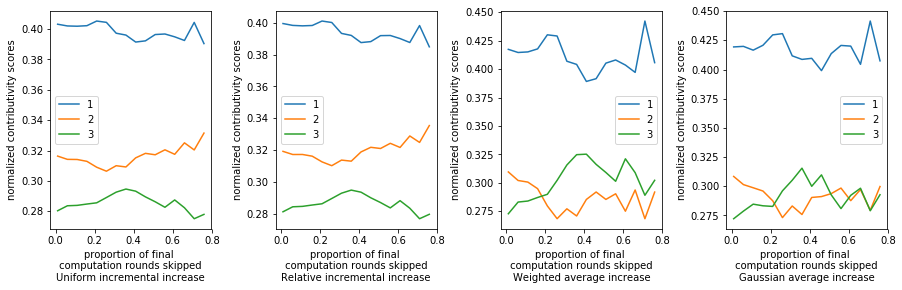

In [40]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (1)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

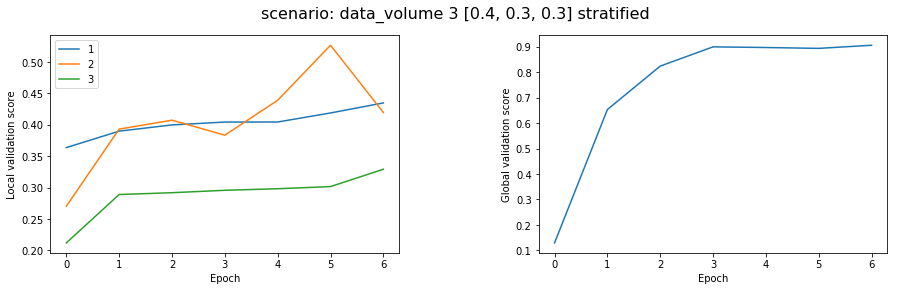

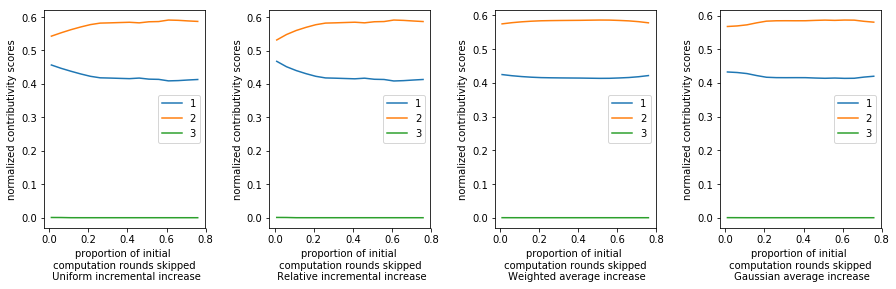

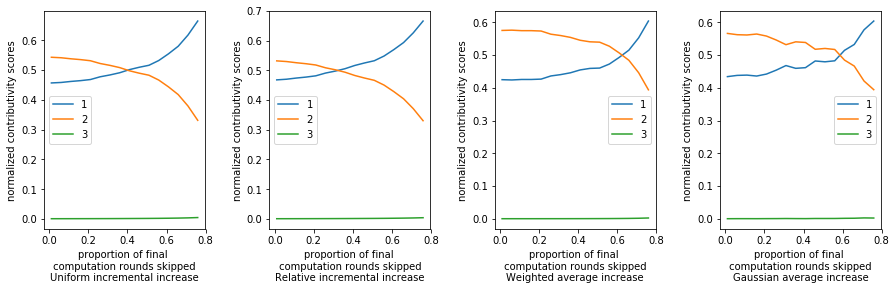

In [41]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (2)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [42]:
aggregated_score_function (score_matrix_per_partner,score_matrix_collective_models, "Uniform incremental increase",
                               init_comp_rounds_skipped, final_comp_rounds_skipped)

(array([0.11642935, 0.13842089, 0.00017633]),
 array([0.45653811, 0.54277048, 0.00069141]))

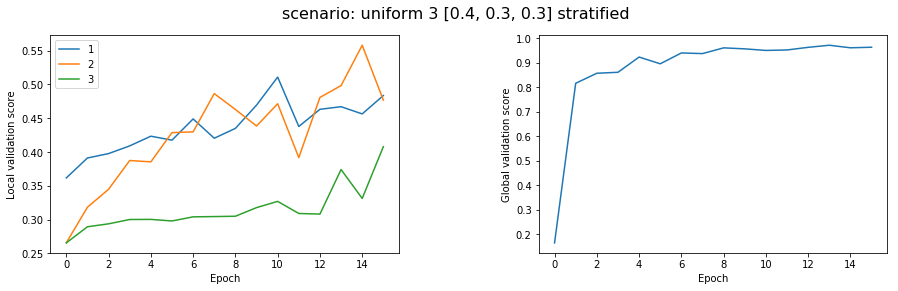

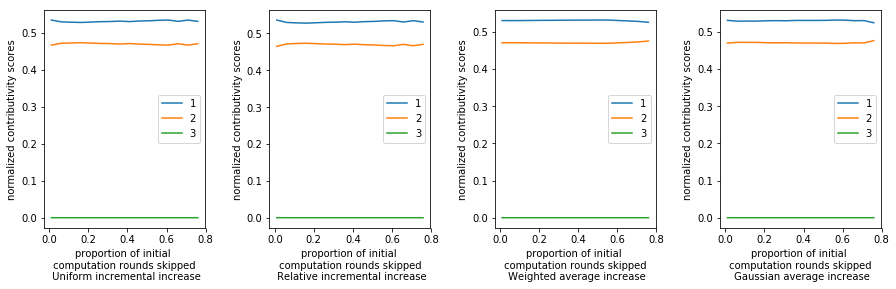

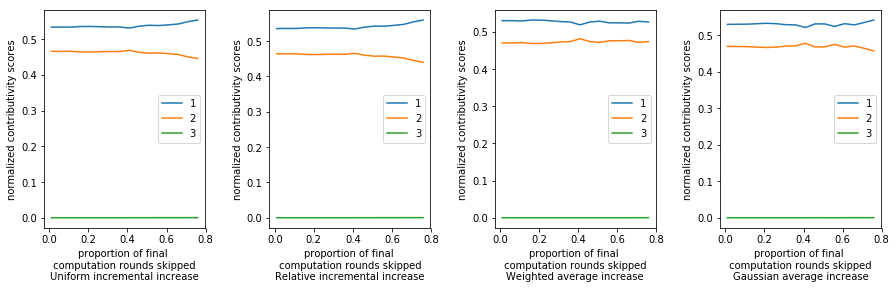

In [43]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (3)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

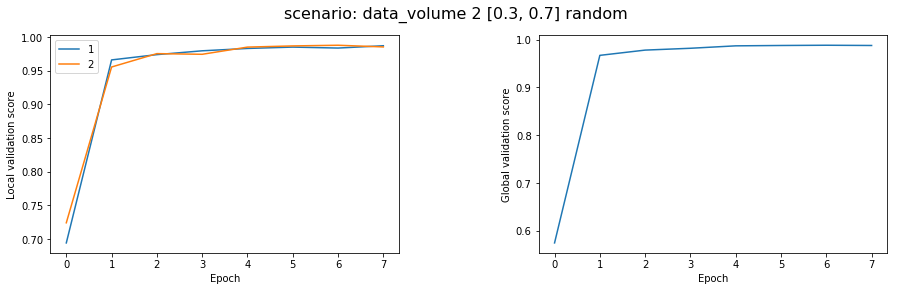

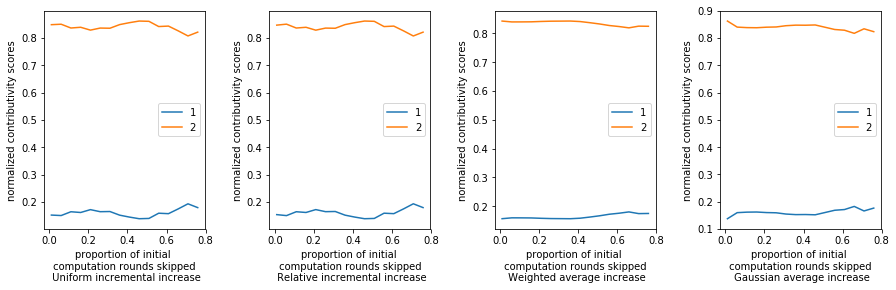

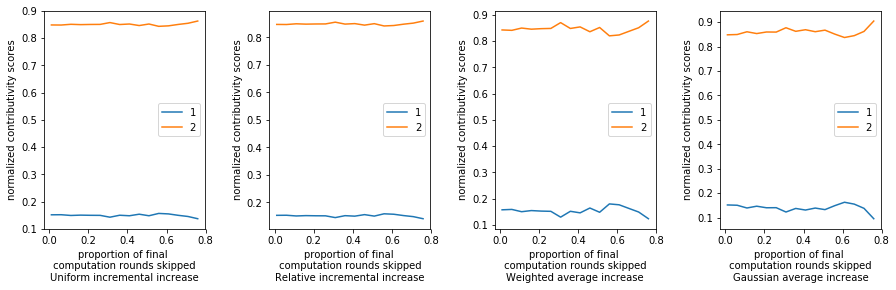

In [44]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (4)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

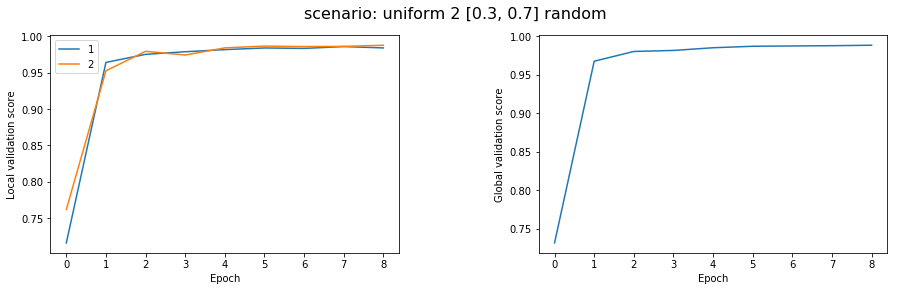

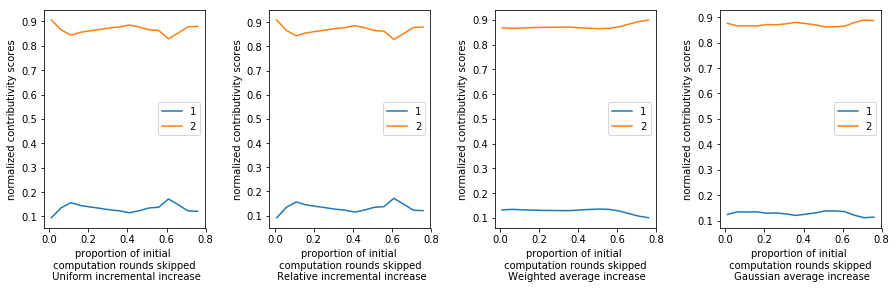

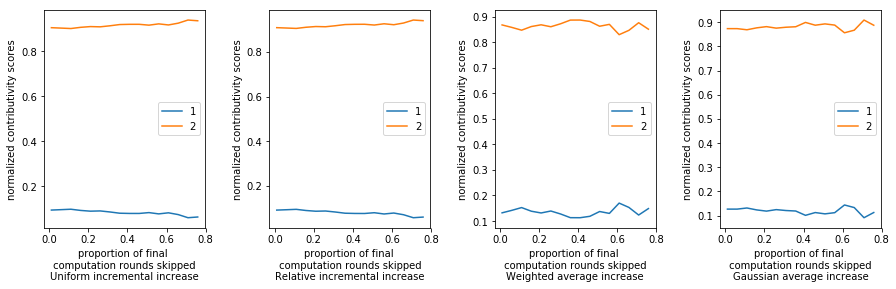

In [45]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (5)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

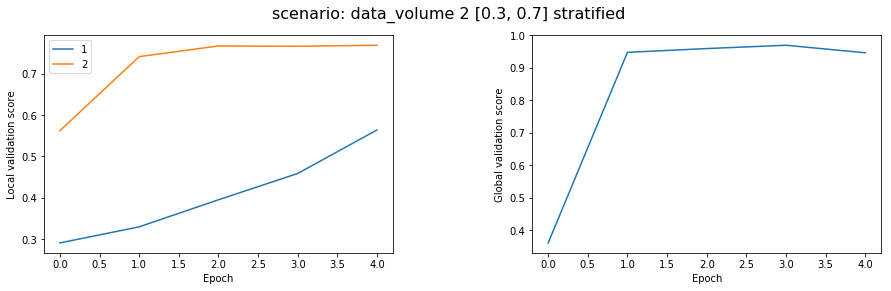

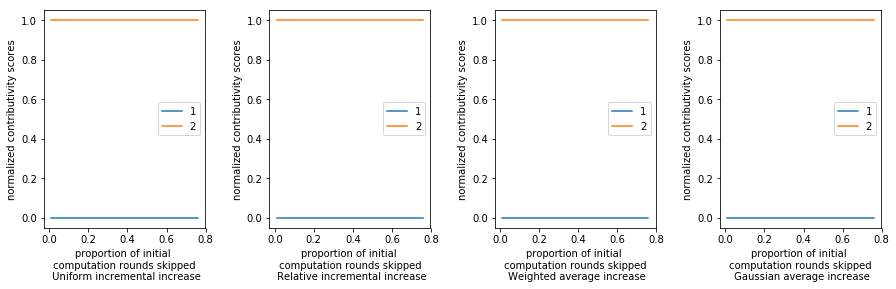

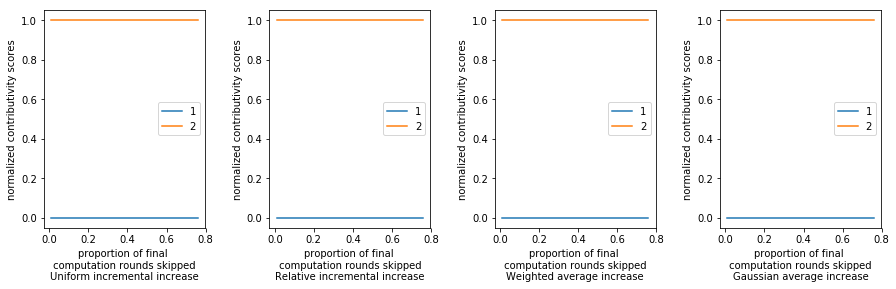

In [46]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (6)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

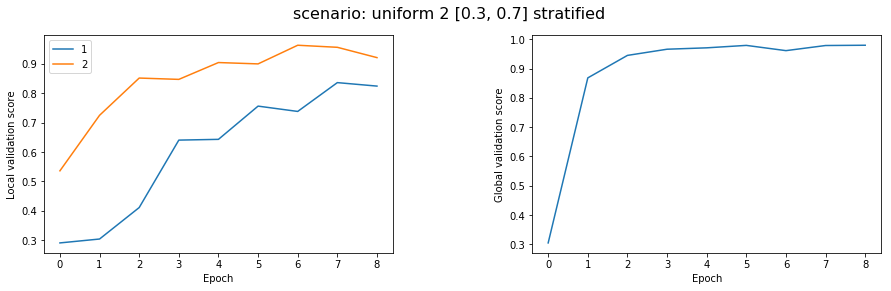

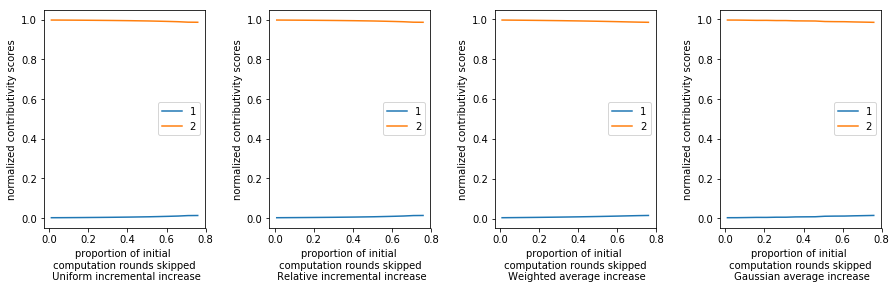

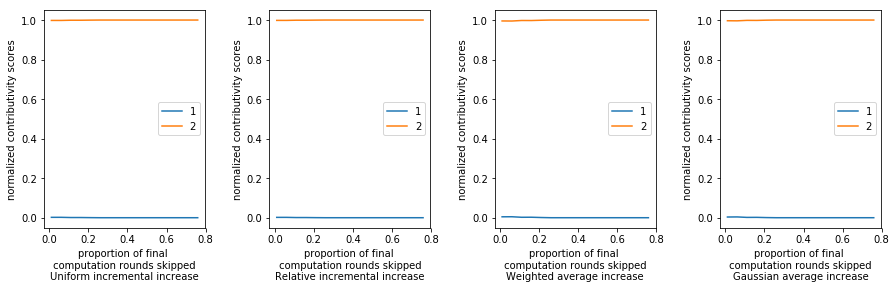

In [47]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (7)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

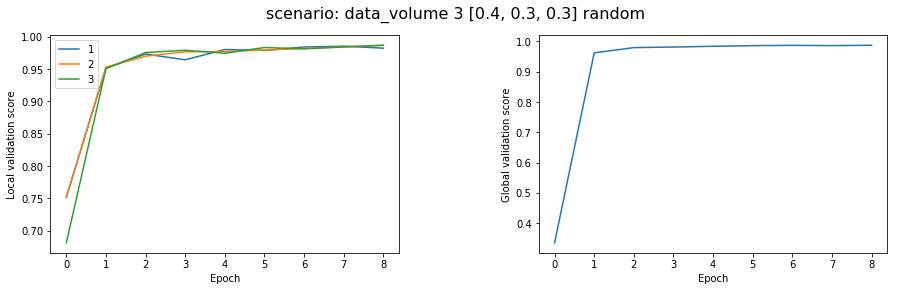

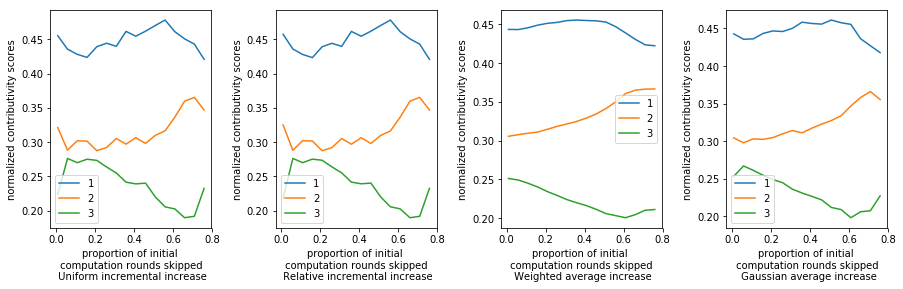

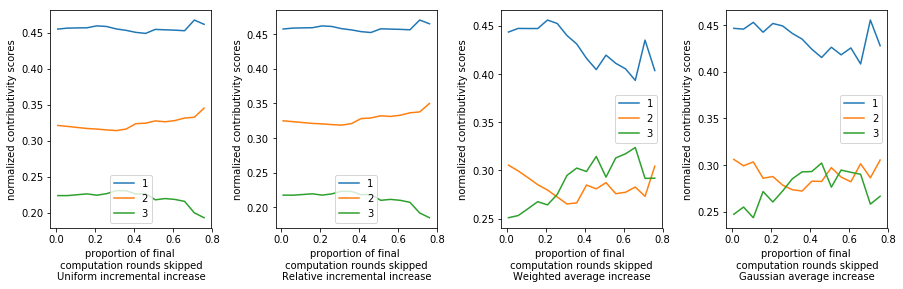

In [48]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (8)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

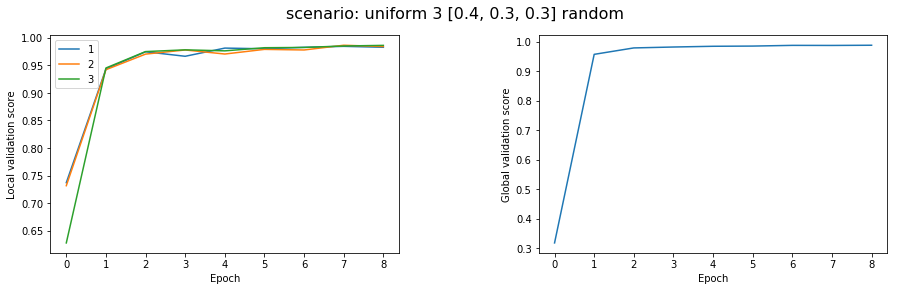

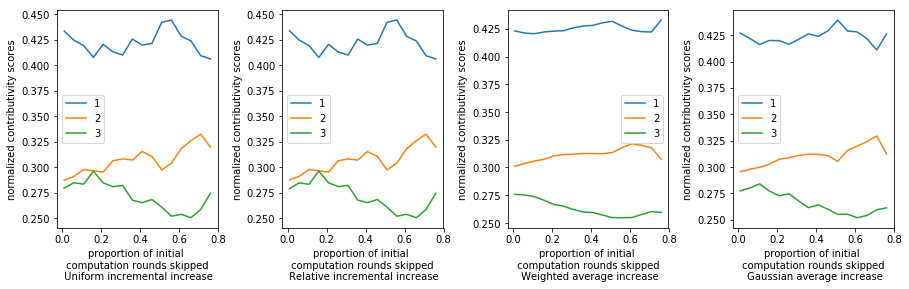

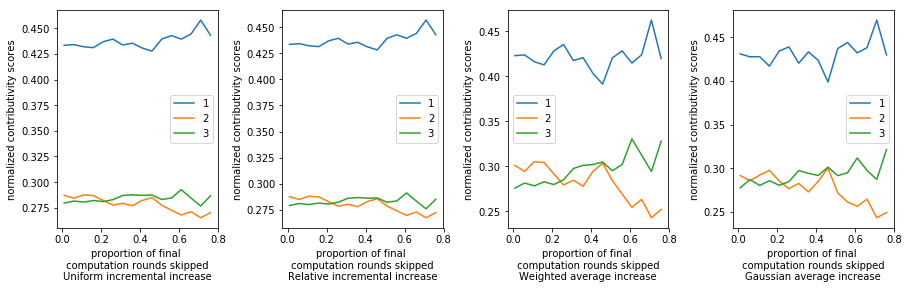

In [49]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (9)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)